# Own implementation of the EDMD algorithm (task 2) and application to two examples (tasks 3 and 4)

The Extended Dynamic Mode Decomposition (EDMD) is a method to approximate the Koopman operator $\mathbf{K}$ and the correpsonding triples of Koopman eigenvalue, eigenfunction and mode. Where $\{(\mu_k, \phi_k, v_k)\}^K_{k=1}$ is the set of K triples required to reconstruct the full state. (See Williams et al., 2015)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.linalg

### Task 2: Own implementation of the EDMD algorithm

Requirements:\
Data set with 'labeled data', i.e. $F(x_i) = y_i$\
Dictionary of observables, i.e. basisfunctions (best choice depends on data set)

In [2]:
# Calculate Koopman operator K
def calc_K(X, Y, D):
    M = np.shape(X)[1]
    # evaluate D with values from X
    phi_x = []
    for i in range(M):
        phi_x.append(D(X[0,i],X[1,i]))
    phi_x = np.array(phi_x)
    # evaluate D with values from Y
    phi_y = []
    for i in range(M):
        phi_y.append(D(Y[0,i],Y[1,i]))
    phi_y = np.array(phi_y)
    # calulate G and A matrices
    G = 1/M * phi_x.T @ phi_x
    A = 1/M * phi_x.T @ phi_y
    # solve for K
    K = np.linalg.pinv(G) @ A
    return K

Eigenfunction of $\mathbf{K}$: $\phi_j = \Psi \zeta_j$ with $\zeta_j$ being the j-th eigenvector of $\mathbf{K}$

In [3]:
# caluclate eigenvalues, -vectors, -functions
def calc_eig(K, D):
    eigenvalues, left_evecs, right_evecs = scipy.linalg.eig(K, left=True, right=True)
    #sort eigenvalues (and associated eigenvectors) from big to small
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    right_evecs = right_evecs[:, idx]
    left_evecs = left_evecs[:,idx]#return left eigenvectors for mode calculation
    #calculate eigenfunctions
    eigenfunctions = lambda x, y : D(x,y) @ right_evecs
    return eigenvalues, left_evecs, eigenfunctions

Koopman modes: $\mathbf{V} = (\mathbf{W}^* \mathbf{B})^T$ with $\mathbf{W}^*$ holding the left eigenvectors.

In [4]:
# calculate the Koopman modes
def calc_modes(eigenvectors, D):#no D?
    #eigenvectors_inverted = np.linalg.inv(eigenvectors)
    B = np.zeros((np.shape(eigenvectors)[-1], 2)) #B should be (K,N) where N is dim of data points
    B[1,0] = 1# for the example from Williams et al.
    B[5,1] = 1# for the example from Williams et al.
    #try with left eigenvectors for full state observable
    modes = (eigenvectors @ B).T
    #modes = (np.conj(eigenvectors).T @ B).T
    
    return modes

In [5]:
# perform EDMD algorithm
def EDMD(X, Y, D):
    K = calc_K(X, Y, D)
    eigenvalues, eigenvectors, eigenfunctions = calc_eig(K, D)
    modes = calc_modes(eigenvectors, D)
    return eigenvalues, eigenvectors, modes, eigenfunctions

### Task 3: Linear example from Williams et al., 2015
Analyical solution vs. EDMD approximation with our code (vs. Williams' solution in the report)\
Example: $x(n+1) = Jx(n) = \begin{bmatrix} 0.9 & -0.1 \\ 0.0 & 0.8 \end{bmatrix} x(n)$

Analytical solution:

In [8]:
# analytical solution for eigenfunctions and -values
def sol_func(x, y, i, j):
    return ((x - y)/(2**(1/2)))**i * y**j

def sol_evals(i, j):
    return (0.9)**i * (0.8)**j

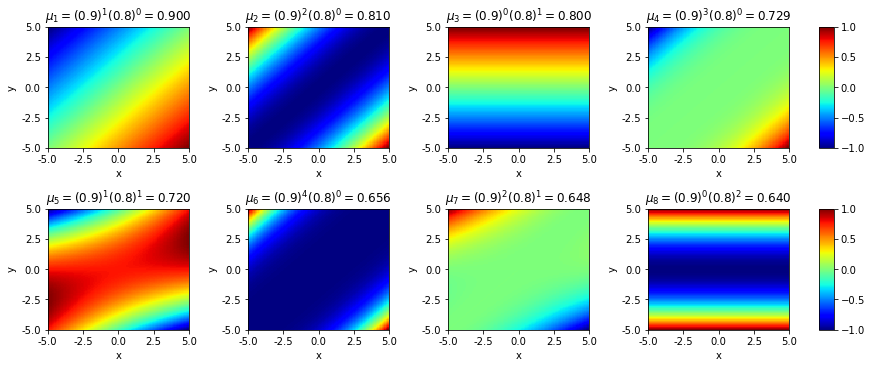

In [23]:
# plot first 8 nontrivial eigenfunctions (+ scaling) like in Williams et al. 2015 - analytical Koopman eigenfunctions
x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)
X, Y = np.meshgrid(x, y)
fig, axs = plt.subplots(2,4, figsize=(12,5), constrained_layout=True)
cmap = mpl.cm.jet
ij = [(1,0),(2,0),(0,1),(3,0),(1,1),(4,0),(2,1),(0,2)]
for i in range(1,9):
    values = sol_func(X,Y, *ij[i-1])
    ax = axs.flat[i-1]
    pcm = ax.pcolormesh(np.real(values), cmap=cmap)
    ax.set_xticks([0,25,50,75,100])
    ax.set_xticklabels(np.linspace(-5,5,5))
    ax.set_yticks([0,25,50,75,100])
    ax.set_yticklabels(np.linspace(-5,5,5))
    ax.set_title('$\mu_{%d}=(0.9)^{%d}(0.8)^{%d}=%.3f$' %(i,*ij[i-1],sol_evals(*ij[i-1])))
    #ax.set_title('{:.3f}'.format(eigenvalues[i]))#for complex numbers, but here im-part=0
    ax.set_xlabel('x')
    ax.set_ylabel('y')


norm = mpl.colors.Normalize(vmin=-1, vmax=1)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,:])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,:])
plt.show()

Solution with EDMD:

In [11]:
# Create the data
J = np.array([[0.9, -0.1],[0.0, 0.8]])
# X normal distributed with size (2,100)
X = np.random.default_rng().normal(size=(2,100))
# Y as result of J @ X
Y = J @ X

In [12]:
# Create the dictionary like in Williams et al. 2015
# define Hermite polynomials
def H0(x):
    return 1
def H1(x):
    return 2 * x
def H2(x):
    return 4 * x**2 - 2
def H3(x):
    return 8 * x**3 - 12 * x
def H4(x):
    return 16 * x**4 - 48 * x**2 + 12

# define dictionary
D = lambda x,y : [H0(x) * H0(y),H0(x)*H1(y),H0(x) * H2(y),H0(x)*H3(y),H0(x) * H4(y),
                  H1(x) * H0(y),H1(x)*H1(y),H1(x) * H2(y),H1(x)*H3(y),H1(x) * H4(y),
                  H2(x) * H0(y),H2(x)*H1(y),H2(x) * H2(y),H2(x)*H3(y),H2(x) * H4(y),
                  H3(x) * H0(y),H3(x)*H1(y),H3(x) * H2(y),H3(x)*H3(y),H3(x) * H4(y),
                  H4(x) * H0(y),H4(x)*H1(y),H4(x) * H2(y),H4(x)*H3(y),H4(x) * H4(y)]

In [13]:
# apply EDMD to obtain eigenvalues and eigenfunctions
eigenvalues, eigenvectors, modes, eigenfunctions = EDMD(X, Y, D)

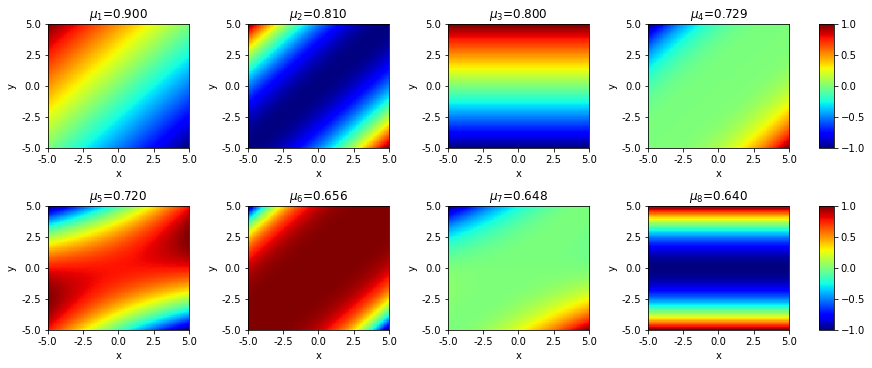

In [24]:
# plot first 8 nontrivial eigenfunctions (+ scaling) like in Williams et al. 2015 - EDMD Koopman eigenfunctions
x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)
X, Y = np.meshgrid(x, y)
fig, axs = plt.subplots(2,4, figsize=(12,5), constrained_layout=True)
cmap = mpl.cm.jet
for i in range(1,9):
    values = eigenfunctions(X,Y)[i]
    ax = axs.flat[i-1]
    pcm = ax.pcolormesh(np.real(values), cmap=cmap)
    ax.set_xticks([0,25,50,75,100])
    ax.set_xticklabels(np.linspace(-5,5,5))
    ax.set_yticks([0,25,50,75,100])
    ax.set_yticklabels(np.linspace(-5,5,5))
    ax.set_title('$\mu_{%d}$=%.3f' %(i,np.real(eigenvalues[i])))
    #ax.set_title('{:.3f}'.format(eigenvalues[i]))#for complex numbers, but here im-part=0
    ax.set_xlabel('x')
    ax.set_ylabel('y')


norm = mpl.colors.Normalize(vmin=-1, vmax=1)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,:])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,:])
plt.show()

### Task 4: Example from crowd dynamics
Using the example from exercise 5 task 5: 'MI_timesteps.txt' containing the number of pedestrians in varoius measurement areas at campus Garching. The EDMD algorithm can be applied to a single, multiple, or all measurement areas as demonstrated below.\
In the report: interpretation (and compare to datafold code)

In [15]:
# load data
data = np.loadtxt(fname='MI_timesteps.txt', skiprows=1001)#skipping description + 1000 time steps (burn-in period)
print('Shape of whole data set: '+str(np.shape(data)))
T = data[:,0]#time
X1 = data[:,1]#measurement areas 1-9
X2 = data[:,2]
X3 = data[:,3]
X4 = data[:,4]
X5 = data[:,5]
X6 = data[:,6]
X7 = data[:,7]
X8 = data[:,8]
X9 = data[:,9]

Y1 = X1[1:]# if X is timestep n, Y is timestep n+1
X1 = X1[:-1]#last element cannot be used
X1 = X1.reshape((np.size(X1),1))
Y1 = Y1.reshape((np.size(Y1),1))
print('Shape of X1: '+str(np.shape(X1)))
print('Shape of Y1: '+str(np.shape(Y1)))

all_X = data[:,1:]
all_Y = all_X[1:,:]
all_X = all_X[:-1,:]
print('Shape of all_X: '+str(np.shape(all_X)))
print('Shape of all_Y: '+str(np.shape(all_Y)))

Shape of whole data set: (14001, 10)
Shape of X1: (14000, 1)
Shape of Y1: (14000, 1)
Shape of all_X: (14000, 9)
Shape of all_Y: (14000, 9)


In [17]:
# apply EDMD to obtain eigenvalues and eigenfunctions
evals, evecs, mos, efuncs = EDMD(X1, Y1, D)

In [18]:
#evals

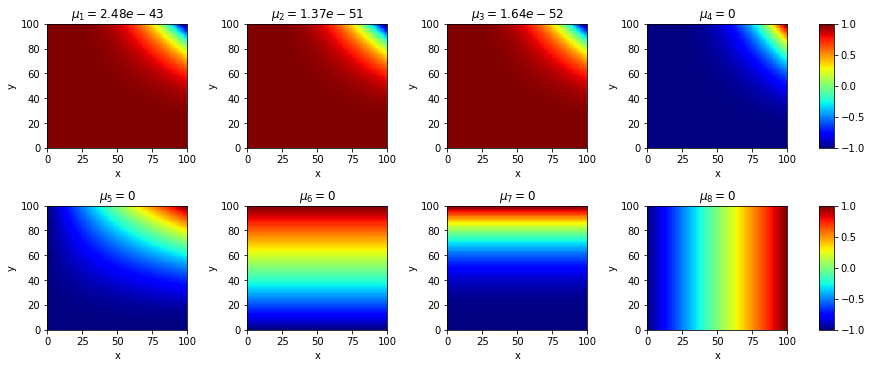

In [19]:
x = np.linspace(X1.min(),X1.max(),100)#perhaps other limits
y = np.linspace(X1.min(),X1.max(),100)
X, Y = np.meshgrid(x, y)
fig, axs = plt.subplots(2,4, figsize=(12,5), constrained_layout=True)
cmap = mpl.cm.jet
for i in range(1,9):
    values = efuncs(X,Y)[i]
    ax = axs.flat[i-1]
    pcm = ax.pcolormesh(np.real(values), cmap=cmap)
    #ax.set_xticks([0,25,50,75,100])
    #ax.set_xticklabels(np.linspace(-5,5,5))
    #ax.set_yticks([0,25,50,75,100])
    #ax.set_yticklabels(np.linspace(-5,5,5))
    ax.set_title('$\mu_{%d}=%.3g$' %(i,np.real(evals[i])))
    #ax.set_title('{:.3f}'.format(eigenvalues[i]))#for complex numbers, but here im-part=0
    ax.set_xlabel('x')
    ax.set_ylabel('y')


norm = mpl.colors.Normalize(vmin=-1, vmax=1)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,:])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,:])
plt.show()

In [21]:
# apply EDMD to obtain eigenvalues and eigenfunctions
all_evals, all_evecs, all_mos, all_efuncs = EDMD(all_X, all_Y, D)

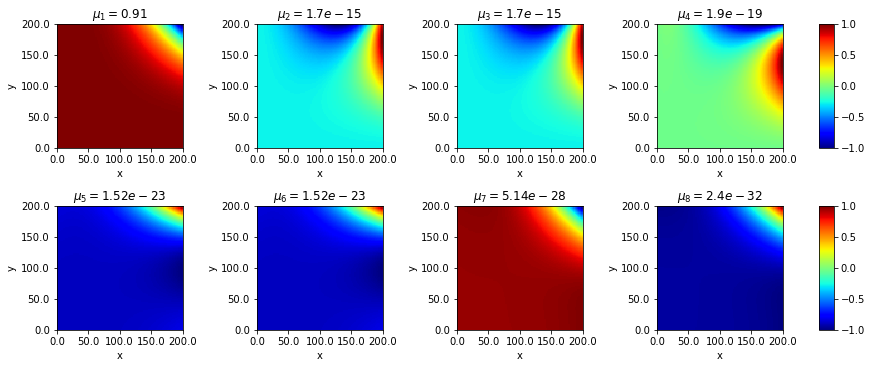

In [22]:
x = np.linspace(all_X.min(),all_X.max(),100)
y = np.linspace(all_X.min(),all_X.max(),100)
X, Y = np.meshgrid(x, y)
fig, axs = plt.subplots(2,4, figsize=(12,5), constrained_layout=True)
cmap = mpl.cm.jet
for i in range(1,9):
    values = all_efuncs(X,Y)[i]
    ax = axs.flat[i-1]
    pcm = ax.pcolormesh(np.real(values), cmap=cmap)
    ax.set_xticks([0,25,50,75,100])
    ax.set_xticklabels(np.linspace(all_X.min(),all_X.max(),5))
    ax.set_yticks([0,25,50,75,100])
    ax.set_yticklabels(np.linspace(all_X.min(),all_X.max(),5))
    ax.set_title('$\mu_{%d}=%.3g$' %(i,np.real(all_evals[i])))
    #ax.set_title('{:.3f}'.format(eigenvalues[i]))#for complex numbers, but here im-part=0
    ax.set_xlabel('x')
    ax.set_ylabel('y')


norm = mpl.colors.Normalize(vmin=-1, vmax=1)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,:])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,:])
plt.show()